<!-- File automatically generated using DocOnce (https://github.com/doconce/doconce/):
doconce format ipynb sparsity.do.txt  -->

# Demo - Sparse Chebyshev-Petrov-Galerkin methods for differentiation
**Mikael Mortensen** (email: `mikaem@math.uio.no`), Department of Mathematics, University of Oslo.

Date: **October 26, 2021**

**Summary.** This demo explores how to use sparse Chebyshev-Petrov-Galerkin methods for finding Chebyshev coefficients of
the derivatives of smooth functions. We will compare the methods to the more commonly adopted
recursion methods that are found in most spectral textbooks.

<h1 id="table_of_contents">

Table of contents</h1>

<div class='toc'>
<p><a href="#Introduction"> Introduction </a></p>
<p><a href="#Differentiation"> Differentiation </a></p>
<p><a href="#Recursion"> Recursion </a></p>
</div>
<br>

## Introduction

The Chebyshev polynomials of the first kind can be defined as

<!-- Equation labels as ordinary links -->
<div id="eq:chebTU"></div>

$$
\begin{equation}
\label{eq:chebTU} \tag{1}
    T_k(x) = \cos(k\theta),
\end{equation}
$$

where $\theta = \cos^{-1} x$, $k$ is a positive integer and $x \in [-1, 1]$.
The Chebyshev polynomials span the discrete space $S_N = \text{span}\{T_k\}_{k=0}^{N-1}$,
and a function $u(x)$ can be approximated in this space as

<!-- Equation labels as ordinary links -->
<div id="eq:uT"></div>

$$
\begin{equation}
u_N(x) = \sum_{k=0}^{N-1} \hat{u}_k T_k(x).
\label{eq:uT} \tag{2}
\end{equation}
$$

Consider the expansion of the function $u(x)=\sin(\pi x)$, created in `shenfun` as

In [1]:
from shenfun import *
import sympy as sp
x = sp.Symbol('x')
ue = sp.sin(sp.pi*x)
N = 16
SN = FunctionSpace(N, 'C')
uN = Function(SN, buffer=ue)
uN

Function([-4.85722573e-17,  5.69230686e-01, -1.38366483e-16,
          -6.66916672e-01,  7.03290092e-17,  1.04282369e-01,
          -5.17536910e-17, -6.84063354e-03, -2.94392336e-17,
           2.50006885e-04,  8.57780639e-18, -5.85024831e-06,
          -6.09960263e-17,  9.53478051e-08, -1.04132138e-16,
          -1.15621280e-09])

The Python Function `uN` represents the expansion ([2](#eq:uT)), and the printed
values represent $\boldsymbol{\hat{u}} = \{\hat{u}_k\}_{k=0}^{N-1}$. The expansion is fairly well resolved since
the highest values of $\{\hat{u}_k\}_{k=0}^{N-1}$ approach 0.
Note that the coefficients obtained are based on interpolation at
quadrature points and they do not agree completely with the coefficients truncated from an
infinite series $u(x) = \sum_{k=0}^{\infty} \hat{u}_k T_k$. The obtained series is
often denoted as $u_N(x) = I_N u(x)$, where $I_N$ is an interpolation operator.
Under the hood the coefficients are found by projection using quadrature for the integrals:
find $u_N \in S_N$ such that

$$
(u_N-u, v)_{\omega^{-1/2}} = 0, \quad \forall v \in S_N,
$$

where $\omega = (1-x^2)$ and the scalar product notation
$(a, b)_{\omega^{-1/2}} = \sum_{j=0}^{N-1} a(x_j)b(x_j)\omega_j \approx \int_{-1}^{1} a(x)b(x) \omega(x)^{-1/2} dx$,
where $\{\omega_j\}_{j=0}^{N-1}$ are the quadrature weights. The quadrature approach ensures
that $u(x_j) = u_N(x_j)$ for all quadrature points $\{x_j\}_{j=0}^{N-1}$.
In `shenfun` we compute the following under the hood: insert for $u_N = \sum_{j=0}^{N-1} \hat{u}_j T_j$,
$u=\sin(\pi x)$ and $v = T_k$ to get

$$
\sum_{j=0}^{N-1}(T_j, T_k)_{\omega^{-1/2}} \hat{u}_j = (\sin(\pi x), T_k)_{\omega^{-1/2}},
$$

This has now become a linear algebra problem, and we recognise the matrix $d^{(0)}_{kj} = (T_j, T_k)_{\omega^{-1/2}}=c_k \pi /2 \delta_{kj}$,
where $\delta_{kj}$ is the Kronecker delta function, and $c_0=2$ and $c_k=1$ for $k>0$.
The problem is solved trivially since $d^{(0)}_{kj}$ is diagonal,
and thus

$$
\hat{u}_k = \frac{2}{c_k \pi} (\sin(\pi x), T_k)_{\omega^{-1/2}}, \quad \forall \, k\in I^N,
$$

where $I^N = \{0, 1, \ldots, N-1\}$.
We can compare this to the truncated coefficients, where the integral $(\sin(\pi x), T_k)_{\omega^{-1/2}}$
is computed with high precision. To this end we could use adaptive quadrature, or symbolic integration
with sympy, but it is sufficient to use a large enough number of polynomials to fully resolve the
function. Below we find this number to be 22 and we see that the absolute error in
the highest wavenumber $\hat{u}_{15} \approx 10^{-11}$.

In [2]:
SM = FunctionSpace(0, 'C')
uM = Function(SM, buffer=ue, abstol=1e-16, reltol=1e-16)
print(uM[:N] - uN[:N])
print(len(uM))

[ 8.20051098e-18  1.11022302e-16  1.22890593e-17 -1.11022302e-16
 -4.29912860e-18  5.55111512e-17  8.53325551e-17 -2.44596010e-16
  1.85259266e-17 -6.84673672e-17  6.31265804e-17  4.99434343e-16
  1.63192838e-16 -7.76732293e-14  1.21113576e-16  1.05743425e-11]
22


## Differentiation

Let us now consider the $n$'th derivative of $u(x)$ instead, denoted here as $u^{(n)}$.
We want to find $u^{(n)}$ in the space $S_N$, which means that we want to obtain
the following expansion

$$
u_N^{(n)} = \sum_{k=0}^{N-1} \hat{u}^{(n)}_k T_k.
$$

First note that this expansion is not the same as the derivative of
the previously found $u_N$, which is

$$
(u_N)^{(n)} = \sum_{k=0}^{N-1} \hat{u}_k T^{(n)}_k,
$$

where $T^{(n)}_k$ is the $n$'th derivative of $T_k$, a polynomial of order $k-n$.
We again use projection to find $u_N^{(n)} \in S_N$ such that

$$
(u_N^{(n)}-u^{(n)}, v)_{\omega^{-1/2}} = 0, \quad \forall v \in S_N.
$$

Inserting for $u_N^{(n)}$ and $u^{(n)} = (u_N)^{(n)}$ we get

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
    \sum_{j=0}^{N-1}(T_j, T_k)_{\omega^{-1/2}} \hat{u}_j^{(n)} = (T_j^{(n)}, T_k)_{\omega^{-1/2}} \hat{u}_j, 
\label{_auto1} \tag{3}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}  
    \sum_{j=0}^{N-1} d^{(0)}_{kj} \hat{u}_j^{(n)}  = \sum_{j=0}^{N-1} d^{(n)}_{kj} \hat{u}_j,
\label{_auto2} \tag{4}
\end{equation}
$$

where $d^{(n)}_{kj} = (T_j^{(n)}, T_k)_{\omega^{-1/2}}$.
We compute $\hat{u}_k^{(n)}$ by inverting the diagonal $d^{(0)}_{kj}$

<!-- Equation labels as ordinary links -->
<div id="eq:fhat"></div>

$$
\begin{equation}
\hat{u}_k^{(n)} = \frac{2}{c_k \pi} \sum_{j=0}^{N-1} d^{(n)}_{kj} \hat{u}_j, \quad \forall \, k \in I^{N}.
\label{eq:fhat} \tag{5}
\end{equation}
$$

The matrix $d^{(n)}_{kj}$ is upper triangular, and the last $n$ rows are zero. Since $d^{(n)}_{kj}$ is
dense the matrix vector product $\sum_{j=0}^{N-1} d^{(n)}_{kj} \hat{u}_j$ is costly
and also susceptible to roundoff errors if the structure of the matrix is
not taken advantage of. But computing it in shenfun
is straightforward, for $n=1$ and $2$:

In [3]:
uN1 = project(Dx(uN, 0, 1), SN)
uN2 = project(Dx(uN, 0, 2), SN)
uN1

Function([-9.55804991e-01, -5.29095427e-15, -3.05007135e+00,
          -4.73748833e-15,  9.51428681e-01, -5.30012041e-15,
          -9.13950067e-02, -4.67907612e-15,  4.37386282e-03,
          -4.20804838e-15, -1.26261106e-04, -4.37960451e-15,
           2.44435655e-06, -2.91569988e-15, -3.46863840e-08,
           0.00000000e+00])

where `uN1` $=u_N^{(1)}$ and `uN2` $=u_N^{(2)}$.
Alternatively, doing all the work that goes on under the hood

In [4]:
u = TrialFunction(SN)
v = TestFunction(SN)
D0 = inner(u, v)
D1 = inner(Dx(u, 0, 1), v)
D2 = inner(Dx(u, 0, 2), v)
w0 = Function(SN) # work array
uN1 = Function(SN)
uN2 = Function(SN)
uN1 = D0.solve(D1.matvec(uN, w0), uN1)
uN2 = D0.solve(D2.matvec(uN, w0), uN2)
uN1

Function([-9.55804991e-01, -5.29095427e-15, -3.05007135e+00,
          -4.73748833e-15,  9.51428681e-01, -5.30012041e-15,
          -9.13950067e-02, -4.67907612e-15,  4.37386282e-03,
          -4.20804838e-15, -1.26261106e-04, -4.37960451e-15,
           2.44435655e-06, -2.91569988e-15, -3.46863840e-08,
           0.00000000e+00])

We can look at the sparsity patterns of $(d^{(1)}_{kj})$ and $(d^{(2)}_{kj})$

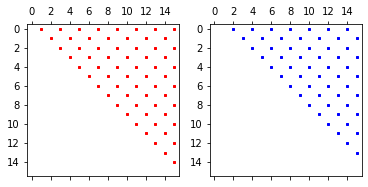

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.spy(D1.diags(), markersize=2, color='r')
ax2.spy(D2.diags(), markersize=2, color='b')

just to see that they are upper triangular. We now ask is there a better and faster
way to get `uN1` and `uN2`? A better approach would involve only sparse
matrices, like the diagonal $(d^{(0)}_{kj})$. But how do we get there?
Most textbooks on spectral methods use fast recursive methods to
find the coefficients $\{\hat{u}_k^{(n)}\}$. Here we will show a fast Galerkin approach.

It turns out that a simple change of test space/function will be sufficient.
Let us first replace the test space $S_N$ with
the Dirichlet space $D_N=\{v \in S_N | v(\pm 1) = 0\}$ using basis
functions $v=T_k-T_{k+2}$ and see
what happens. Because of the two boundary conditions,
the number of degrees of freedom is reduced by two, and we need to use a
space with $N+2$ quadrature points in order to get a square matrix system.
The method now becomes classified as Chebyshev-Petrov-Galerkin, as we
wish to find $u_N^{(1)} \in S_N$ such that

$$
(u_N^{(1)}-u^{(1)}, v)_{\omega^{-1/2}} = 0, \quad \forall v \in D_{N+2}.
$$

The implementation is straightforward

In [6]:
DN = FunctionSpace(N+2, 'C', bc=(0, 0))
v = TestFunction(DN)
D0 = inner(u, v)
D1 = inner(Dx(u, 0, 1), v)
uN11 = Function(SN)
uN11 = D0.solve(D1.matvec(uN, w0), uN11)
print(uN11-uN1)

[ 0.00000000e+00 -7.88860905e-31  0.00000000e+00  0.00000000e+00
  1.11022302e-16 -7.88860905e-31  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.23516474e-22  0.00000000e+00  0.00000000e+00  0.00000000e+00]


and since `uN11 = uN1` we see that we have achived the same result as in
the regular projection. However, the matrices in use now look like

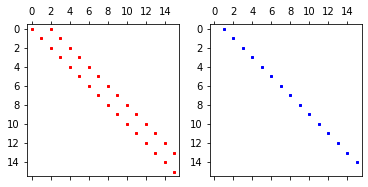

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.spy(D0.diags(), markersize=2, color='r')
ax2.spy(D1.diags(), markersize=2, color='b')

So $(d^{(0)}_{kj})$ now contains two nonzero diagonals, whereas $(d^{(1)}_{kj})$ is
a matrix with one single diagonal. There is no longer a `full` differentiation
matrix, and we can easily perform this projection for millions of degrees of freedom.
What about $(d^{(2)}_{kj})$? We can now use biharmonic test functions that
satisfy four boundary conditions in the space $B_N = \{v \in S_N | v(\pm 1) = v'(\pm 1) =0\}$,
and continue in a similar fashion:

In [8]:
BN = FunctionSpace(N+4, 'C', bc=(0, 0, 0, 0))
v = TestFunction(BN)
D0 = inner(u, v)
D2 = inner(Dx(u, 0, 2), v)
uN22 = Function(SN)
uN22 = D0.solve(D2.matvec(uN, w0), uN22)
print(uN22-uN2)

[-6.16153958e-12 -2.01002713e+00 -5.88073092e-12  1.53351702e-01
 -2.35856677e-12 -6.03926282e-03 -8.05991953e-13  1.47222318e-04
 -2.01978482e-13 -2.61304093e-06 -7.57306469e-29  2.71050543e-20
 -1.26217745e-29  2.11758237e-22  0.00000000e+00  0.00000000e+00]


We get that `uN22 = uN2`, so the Chebyshev-Petrov-Galerkin projection works. The matrices involved are now

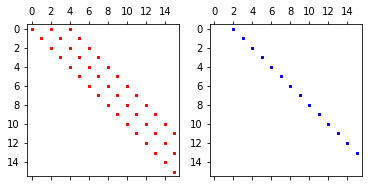

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.spy(D0.diags(), markersize=2, color='r')
ax2.spy(D2.diags(), markersize=2, color='b')

So there are now three nonzero diagonals in $(d^{(0)}_{kj})$, whereas the differentiation matrix
$(d^{(2)}_{kj})$ contains only one nonzero diagonal.

Why does this work so well? The Chebyshev polynomials and their derivatives satisfy the following orthogonality relation

<!-- Equation labels as ordinary links -->
<div id="eq:orthon"></div>

$$
\begin{equation}
\label{eq:orthon} \tag{6}
  \int_{-1}^{1} T^{(n)}_j T^{(n)}_k \omega^{n-1/2} dx = \alpha^{n}_k \delta_{kj}, \quad \text{for}\, n \ge 0,
\end{equation}
$$

where

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
    \alpha^n_k = \frac{c_{k+n}\pi k (k+n-1)!}{2(k-n)!}.
\label{_auto3} \tag{7}
\end{equation}
$$

So when we choose a test function $\omega^n T^{(n)}_k$ and a trial function $T_j$,
we get the diagonal differentiation matrix

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
  d^{(n)}_{kj} = \int_{-1}^{1} T^{(n)}_j (\omega^n T^{(n)}_k) \omega^{-1/2} dx = \alpha^{n}_k \delta_{kj}, \quad \text{for}\, n \ge 0.
\label{_auto4} \tag{8}
\end{equation}
$$

The two chosen test functions above are both proportional to $\omega^n T^{(n)}_k$. More precisely,
$T_k-T_{k+2} = \frac{2}{k+1} \omega T^{(1)}_{k+1}$ and the biharmonic test function is
$T_k-\frac{2(k+2)}{k+3}T_{k+2} + \frac{k+1}{k+3}T_{k+4} = \frac{4 \omega^2T^{(2)}_{k+2}}{(k+2)(k+3)}$.
Using these very specific test functions correponds closely to using the Chebyshev
recursion formulas that are found in most textbooks. Here they are adapted to
a Chebyshev-Petrov-Galerkin method, where we simply choose test and trial functions and everything
else falls into place in a few lines of code.

## Recursion

Let us for completion show how to
find $\hat{u}_N^{(1)}$ with a recursive approach. The Chebyshev polynomials
satisfy

<!-- Equation labels as ordinary links -->
<div id="eq:Trec1"></div>

$$
\begin{equation}
2T_k = \frac{1}{k+1}T'_{k+1}- \frac{1}{k-1} T'_{k-1}, \quad k \ge 1.
\label{eq:Trec1} \tag{9}
\end{equation}
$$

By using this and setting $u' = \sum_{k=0}^{\infty} \hat{u}^{(1)}_k T_k = \sum_{k=0}^{\infty} \hat{u}_k T'_k$
we get

<!-- Equation labels as ordinary links -->
<div id="eq:Trec2"></div>

$$
\begin{equation}
2k\hat{u}_k = c_{k-1}\hat{u}^{(1)}_{k-1} - \hat{u}^{(1)}_{k+1}, \quad k \ge 1.
\label{eq:Trec2} \tag{10}
\end{equation}
$$

Using this recursion on a discrete series, together with $\hat{u}^{(1)}_{N} = \hat{u}^{(1)}_{N-1} = 0$, we get
(see [[canuto]](#canuto) Eq. (2.4.24))

<!-- Equation labels as ordinary links -->
<div id="eq:Trec3"></div>

$$
\begin{equation}
c_k \hat{u}^{(1)}_k = \hat{u}^{(1)}_{k+2} + 2(k+1)\hat{u}_{k+1}, \quad 0 \le k \le N-2,
\label{eq:Trec3} \tag{11}
\end{equation}
$$

which is easily implemented in a (slow) for-loop

In [10]:
f1 = np.zeros(N+1)
ck = np.ones(N); ck[0] = 2
for k in range(N-2, -1, -1):
    f1[k] = (f1[k+2]+2*(k+1)*uN[k+1])/ck[k]
print(f1[:-1]-uN1)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 7.88860905e-31
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.88860905e-31
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


which evidently is exactly the same result. It turns out that this is not strange. If we multiply
([11](#eq:Trec3)) by $\pi/2$, rearrange a little bit and move to a matrix form we get

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
c_k \pi/2 \hat{u}^{(1)}_k -  \pi/2 \hat{u}^{(1)}_{k+2} = (k+1)\pi \hat{u}_{k+1} 
\label{_auto5} \tag{12}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}  
\underbrace{(c_k \pi/2 \delta_{kj} - \pi/2 \delta_{k, j-2})}_{(D^0)_{kj}} \hat{u}^{(1)}_j = \underbrace{(k+1)\pi \delta_{k,j-1}}_{(D^1)_{kj}} \hat{u}_{j} 
\label{_auto6} \tag{13}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}  
D^0 \boldsymbol{\hat{u}} = D^1 \boldsymbol{\hat{u}} 
\label{_auto7} \tag{14}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}  
\boldsymbol{\hat{u}^{(1)}} = (D^0)^{-1} D^1 \boldsymbol{\hat{u}}
\label{_auto8} \tag{15}
\end{equation}
$$

which is exactly how $\boldsymbol{\hat{u}^{(1)}}$ was computed above with the Chebyshev-Petrov-Galerkin approach
(compare with the code line `uN11 = D0.solve(D1.matvec(uN, w0), uN11)`). Not convinced? Check that the matrices
`D0` and `D1` are truly as stated above. The matrices below are printed as dictionaries with diagonal
number as key (main is 0, first upper is 1 etc) and diagonal values as values:

In [11]:
import pprint
DN = FunctionSpace(N+2, 'C', bc=(0, 0))
v = TestFunction(DN)
D0 = inner(u, v)
D1 = inner(Dx(u, 0, 1), v)
pprint.pprint(dict(D0))
pprint.pprint(dict(D1))

{0: array([3.14159265, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633]),
 2: array([-1.57079633, -1.57079633, -1.57079633, -1.57079633, -1.57079633,
       -1.57079633, -1.57079633, -1.57079633, -1.57079633, -1.57079633,
       -1.57079633, -1.57079633, -1.57079633, -1.57079633])}
{1: array([ 3.14159265,  6.28318531,  9.42477796, 12.56637061, 15.70796327,
       18.84955592, 21.99114858, 25.13274123, 28.27433388, 31.41592654,
       34.55751919, 37.69911184, 40.8407045 , 43.98229715, 47.1238898 ,
       50.26548246])}


In conclusion, we have shown that we can use an efficient Chebyshev-Petrov-Galerkin approach to obtain
the discrete Chebyshev coefficients for the derivatives
of a function. By inspection, it turns out that this approach is identical to the common methods based on
well-known Chebyshev recursion formulas.

<!-- ======= Bibliography ======= -->

1. <div id="canuto"></div> **C. Canuto, M. Hussaini, A. Quarteroni and J. T. A.**.  *Spectral Methods in Fluid Dynamics*, *Scientific Computation*, Springer, 2012.